# Runs Above Replacement Modeling

### Name: Alex Xu

In [571]:
#Imports
import numpy as np
import pandas as pd
from collections import Counter
from matplotlib.pyplot import figure
import re
import tqdm
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn import linear_model
import statsmodels.formula.api as smf
from sklearn import metrics
from sklearn.metrics import r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.feature_selection import RFE, SelectKBest, f_regression
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Ridge, Lasso
import xgboost as xgb
import sqlite3
import datetime
import seaborn as sns
import math
import statsmodels.api as sm 

## Problem Statement:

We are trying to build a model that predicted Runs Above Replacement of a player up and including their Age-30 season, the data is collected from 1994-2017.

## Data

In [572]:
people = pd.read_csv('People.csv')
appearances = pd.read_csv('Appearances.csv')
batting = pd.read_csv('Batting.csv')
prospect_rankings = pd.read_excel('historic_prospect_ranking_with_Lahman_ID.xlsx')

In [573]:
people.head()

,playerID,birthYear,birthMonth,birthDay,birthCountry,birthState,birthCity,deathYear,deathMonth,deathDay,...,nameLast,nameGiven,weight,height,bats,throws,debut,finalGame,retroID,bbrefID
0,aardsda01,1981.0,12.0,27.0,USA,CO,Denver,NaN,NaN,NaN,...,Aardsma,David Allan,215.0,75.0,R,R,2004-04-06,2015-08-23,aardd001,aardsda01
1,aaronha01,1934.0,2.0,5.0,USA,AL,Mobile,NaN,NaN,NaN,...,Aaron,Henry Louis,180.0,72.0,R,R,1954-04-13,1976-10-03,aaroh101,aaronha01
2,aaronto01,1939.0,8.0,5.0,USA,AL,Mobile,1984.0,8.0,16.0,...,Aaron,Tommie Lee,190.0,75.0,R,R,1962-04-10,1971-09-26,aarot101,aaronto01
3,aasedo01,1954.0,9.0,8.0,USA,CA,Orange,NaN,NaN,NaN,...,Aase,Donald William,190.0,75.0,R,R,1977-07-26,1990-10-03,aased001,aasedo01
4,abadan01,1972.0,8.0,25.0,USA,FL,Palm Beach,NaN,NaN,NaN,...,Abad,Fausto Andres,184.0,73.0,L,L,2001-09-10,2006-04-13,abada001,abadan01


In [574]:
appearances.head()

,yearID,teamID,lgID,playerID,G_all,GS,G_batting,G_defense,G_p,G_c,...,G_2b,G_3b,G_ss,G_lf,G_cf,G_rf,G_of,G_dh,G_ph,G_pr
0,1871,TRO,NaN,abercda01,1,1.0,1,1.0,0,0,...,0,0,1,0,0,0,0,0.0,0.0,0.0
1,1871,RC1,NaN,addybo01,25,25.0,25,25.0,0,0,...,22,0,3,0,0,0,0,0.0,0.0,0.0
2,1871,CL1,NaN,allisar01,29,29.0,29,29.0,0,0,...,2,0,0,0,29,0,29,0.0,0.0,0.0
3,1871,WS3,NaN,allisdo01,27,27.0,27,27.0,0,27,...,0,0,0,0,0,0,0,0.0,0.0,0.0
4,1871,RC1,NaN,ansonca01,25,25.0,25,25.0,0,5,...,2,20,0,1,0,0,1,0.0,0.0,0.0


In [575]:
batting.head()

,playerID,yearID,stint,teamID,lgID,G,AB,R,H,2B,...,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP
0,abercda01,1871,1,TRO,NaN,1,4,0,0,0,...,0.0,0.0,0.0,0,0.0,NaN,NaN,NaN,NaN,0.0
1,addybo01,1871,1,RC1,NaN,25,118,30,32,6,...,13.0,8.0,1.0,4,0.0,NaN,NaN,NaN,NaN,0.0
2,allisar01,1871,1,CL1,NaN,29,137,28,40,4,...,19.0,3.0,1.0,2,5.0,NaN,NaN,NaN,NaN,1.0
3,allisdo01,1871,1,WS3,NaN,27,133,28,44,10,...,27.0,1.0,1.0,0,2.0,NaN,NaN,NaN,NaN,0.0
4,ansonca01,1871,1,RC1,NaN,25,120,29,39,11,...,16.0,6.0,2.0,2,1.0,NaN,NaN,NaN,NaN,0.0


In [576]:
prospect_rankings.head()

,year,prospect_rank,team_abbr,first_name,last_name,mlbam_id,lahman_id,position
0,1994,1,MON,Cliff,Floyd,114260,floydcl01,LF-OF
1,1994,2,ATL,Chipper,Jones,116706,jonesch06,3B
2,1994,3,BAL,Jeff,Hammonds,115394,hammoje01,RF-CF
3,1994,4,TOR,Alex,Gonzalez,114924,gonzaal01,SS
4,1994,5,TOR,Carlos,Delgado,113232,delgaca01,1B


### Data Cleaning

In [577]:
#Remove years before 1994
appearances = appearances[appearances.yearID >= 1994]
batting = batting[batting.yearID >= 1994]

### Calculate OPS

In [578]:
batting.columns

Index(['playerID', 'yearID', 'stint', 'teamID', 'lgID', 'G', 'AB', 'R', 'H',
       '2B', '3B', 'HR', 'RBI', 'SB', 'CS', 'BB', 'SO', 'IBB', 'HBP', 'SH',
       'SF', 'GIDP'],
      dtype='object')

OPS Formula: OBP + SLUG

$OBP = \frac{H+BB+HBP} {AB+BB+SF+HBP}$

$SLG = \frac{TB}{AB}$

$OPS = \frac{AB*(H+BB+HBP)+TB*(AB+BB+SF+HBP)}{AB*(AB+BB+SF+HBP)}$

In [579]:
batting['OBP'] = (batting['H']+batting['BB']+batting['HBP'])/(batting['AB']+batting['H']+batting['BB']+batting['HBP'])
batting['SLG'] = ((batting['H']-batting['2B']-batting['3B']-batting['HR'])+2*batting['2B']+3*batting['3B']+4*batting['HR'])/batting['AB']
batting['OPS'] = batting['OBP']+batting['SLG']

In [580]:
#Drop rows with no ABs
batting = batting.dropna(subset=['OPS'])

### Calculate League Average OPS by Year

In [581]:
#Weighted average OPS by ABs
def w_avg(batting, OPS, AB):
    d = batting['OPS']
    w = batting['AB']
    return (d * w).sum() / w.sum()

In [582]:
#AL Average OPS
al_batting = batting[batting.lgID == 'AL']
league_avg_OPS = al_batting.groupby('yearID').apply(w_avg, 'OPS', 'AB')

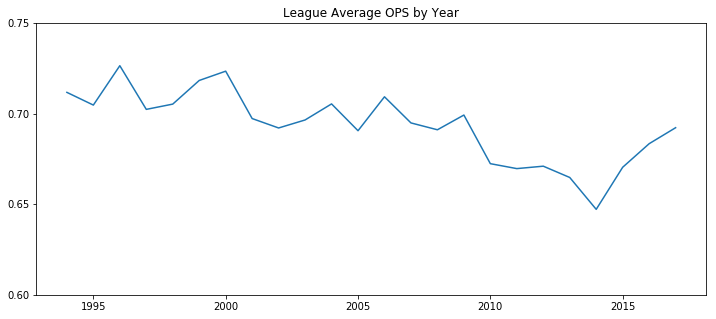

In [583]:
plt.figure(figsize=(12,5),edgecolor='blue')
plt.plot(league_avg_OPS.index, league_avg_OPS.values)
plt.title('League Average OPS by Year')
plt.yticks(np.arange(.6, .75, step=.05))
plt.show()

In [584]:
league_avg_OPS_dict = league_avg_OPS.to_dict()

In [585]:
league_avg_OPS_dict

{1994: 0.7117193350082955,
 1995: 0.7047040000503948,
 1996: 0.7264330561380064,
 1997: 0.7023335213828228,
 1998: 0.7052399556428429,
 1999: 0.7182887261224934,
 2000: 0.7234157148798708,
 2001: 0.6972676073830301,
 2002: 0.6920688399410849,
 2003: 0.6964837504499519,
 2004: 0.7053496061716545,
 2005: 0.6905515891723587,
 2006: 0.7092738678263155,
 2007: 0.6948582868300878,
 2008: 0.6910730823475933,
 2009: 0.6992006444483585,
 2010: 0.6723637362442116,
 2011: 0.6696442514391123,
 2012: 0.6709804106077843,
 2013: 0.6647472005794158,
 2014: 0.647159146845601,
 2015: 0.6703859442448538,
 2016: 0.6833847481576866,
 2017: 0.6922171914782695}

### Calculate Offensive RAA

In [586]:
#Calculate plate appearances and batting average
batting['PA'] = batting['AB'] + batting['BB'] + batting['BB'] + batting['SH'] + batting['SF']
batting['BA'] = batting['H']/batting['AB']

In [587]:
#Function to calculate Offensive RAA
def offense_RAA(row):
    return row['PA'] * (row['OPS'] - league_avg_OPS[row['yearID']])/(3.125)

In [588]:
batting['ORAA'] = batting.apply(lambda row: offense_RAA(row),axis = 1)

### Calculate Defensive RAA

In [589]:
#Take the number of games started as well as defensive + DH appearances (not including pitchers)
def defense_RAA(row):
    gs = row['GS']
    apps = row['G_c']+row['G_1b']+row['G_2b']+row['G_3b']+row['G_ss']+row['G_lf']+row['G_cf']+row['G_rf']+row['G_dh']
    if apps != 0:
        def_multi = gs/apps
        return (def_multi)*((9/150*row['G_c'])+(7/150*row['G_ss'])+(3/150*row['G_2b'])+(2.5/150*row['G_cf'])+(2/150*row['G_3b'])
                            -(7/150*row['G_lf'])-(7/150*row['G_rf'])-(9.5/150*row['G_1b'])-(15/150*row['G_dh']))
    else:
        return None

In [590]:
appearances['DRAA'] = appearances.apply(lambda row: defense_RAA(row),axis = 1)

In [591]:
appearances.dropna(subset=['DRAA'],inplace = True)

### Calculate Total RAA and RAR

In [592]:
#Join tables
merged_RAA = pd.merge(batting,appearances[['yearID','playerID','teamID','G_c', 'G_1b', 'G_2b', 'G_3b', 'G_ss', 'G_lf',
       'G_cf', 'G_rf', 'G_of', 'G_dh','DRAA']],on=['yearID','playerID','teamID'], how='inner')

In [593]:
# Drop Pitchers
merged_RAA = merged_RAA.dropna(subset = ['DRAA'])

In [594]:
# Total RAA and RAR
merged_RAA['RAA'] = merged_RAA['ORAA'] + merged_RAA['DRAA']
merged_RAA['RAR'] = merged_RAA['RAA'] + 20

In [595]:
merged_RAA.columns

Index(['playerID', 'yearID', 'stint', 'teamID', 'lgID', 'G', 'AB', 'R', 'H',
       '2B', '3B', 'HR', 'RBI', 'SB', 'CS', 'BB', 'SO', 'IBB', 'HBP', 'SH',
       'SF', 'GIDP', 'OBP', 'SLG', 'OPS', 'PA', 'BA', 'ORAA', 'G_c', 'G_1b',
       'G_2b', 'G_3b', 'G_ss', 'G_lf', 'G_cf', 'G_rf', 'G_of', 'G_dh', 'DRAA',
       'RAA', 'RAR'],
      dtype='object')

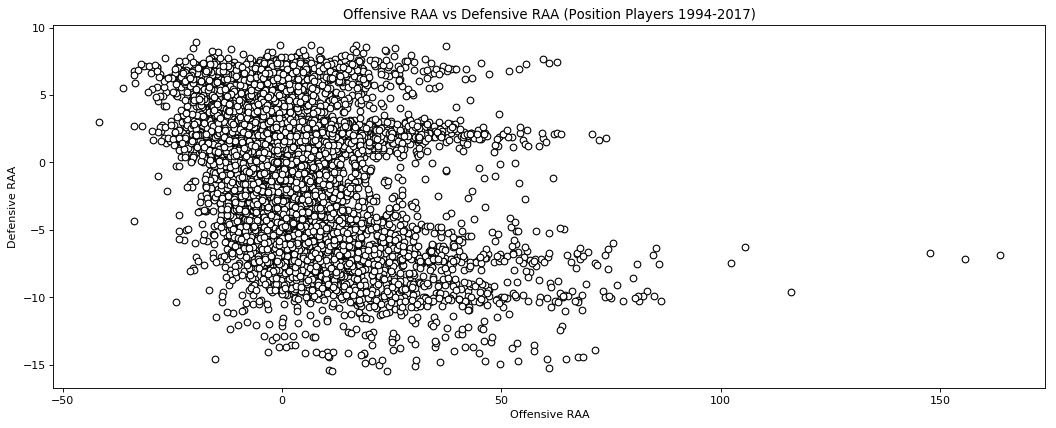

In [596]:
figure(figsize=(16, 6), dpi=80)
plt.scatter(merged_RAA['ORAA'], merged_RAA['DRAA'], c ="white",
            linewidths = 1,
            edgecolor ="black")

plt.title("Offensive RAA vs Defensive RAA (Position Players 1994-2017)")
plt.xlabel("Offensive RAA")
plt.ylabel("Defensive RAA")
plt.show()

In [597]:
top_ORAA = merged_RAA[merged_RAA.ORAA>125]
top_ORAA[['playerID','yearID','ORAA']]

,playerID,yearID,ORAA
4590,bondsba01,2001,155.556226
5266,bondsba01,2002,147.634377
6596,bondsba01,2004,163.695303


As an interesting note, the three greatest offensive seasons in this timeframe by ORAA are Barry Bonds in 2001, 2002, and 2004 which can be seen in the far right of the scatter plot. These are also the only seasons ever recorded to exceed 125 ORAA. These outliers can also be clearly seen on the next plot in the aforementioned years.

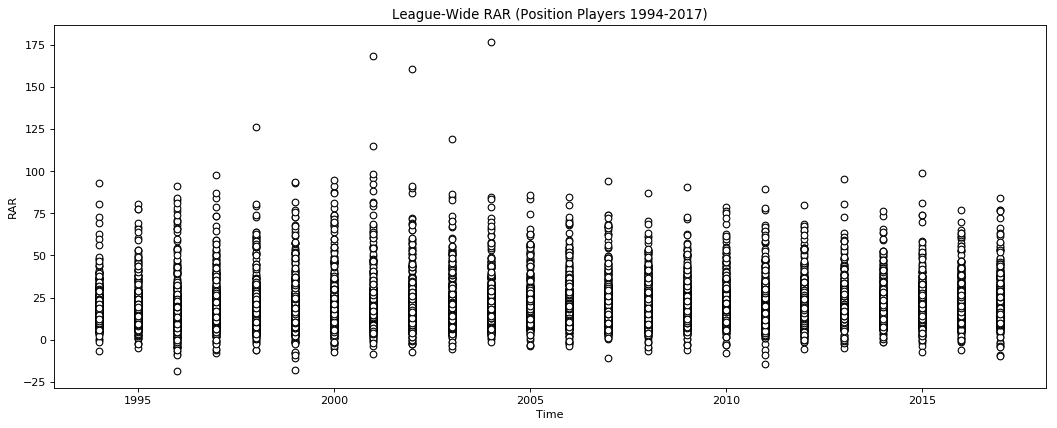

In [598]:
figure(figsize=(16, 6), dpi=80)
plt.scatter(merged_RAA['yearID'], merged_RAA['RAR'], c ="white",
            linewidths = 1,
            edgecolor ="black")

plt.title("League-Wide RAR (Position Players 1994-2017)")
plt.xlabel("Time")
plt.ylabel("RAR")
plt.show()

### Only analyze seasons up to a player's age 30 season

In [599]:
merged_RAA.head()

,playerID,yearID,stint,teamID,lgID,G,AB,R,H,2B,...,G_3b,G_ss,G_lf,G_cf,G_rf,G_of,G_dh,DRAA,RAA,RAR
0,abbotku01,1994,1,FLO,NL,101,345,41,86,17,...,0,99,0,0,0,0,0.0,4.340000,-5.535864,14.464136
1,aldremi01,1994,1,OAK,AL,76,178,23,43,5,...,0,0,21,0,15,35,1.0,-2.126719,-10.134337,9.865663
2,alicelu01,1994,1,SLN,NL,88,205,32,57,12,...,0,0,2,0,0,2,0.0,0.843636,5.311360,25.311360
3,alomaro01,1994,1,TOR,AL,107,392,78,120,25,...,0,0,0,0,0,0,0.0,2.040000,9.459842,29.459842
4,alomasa02,1994,1,CLE,AL,80,292,44,84,15,...,0,0,0,0,0,0,0.0,4.680000,10.545677,30.545677


In [600]:
people["nameFull"] = people['nameFirst']+' '+people['nameLast'] #Combine First and Last Names for joining
people["AfterJuly"] = people['birthMonth']>6
people['AfterJuly'] = people["AfterJuly"].astype(int) #Column to take into account age

In [601]:
people[['debutYear','debutMonth','debutDay']] = people['debut'].str.split('-',expand=True) #Split debut date time
people[['finalYear','finalMonth','finalDay']] = people['finalGame'].str.split('-',expand=True)#Split final game date time
people.dropna(subset=['finalYear'],inplace = True) #Remove players that don't have a final year
people['active'] = (people['finalYear'].astype(int) >= 2017)
#For simplicity, assume that a player is currently active if their Final Game is in 2017

In [602]:
# Join offensive/defensive statistics with descriptive information in 'people' table
merged_RAA = pd.merge(merged_RAA,people[['playerID','nameFull','birthYear','height','bats','throws','debutYear','AfterJuly','finalYear','active']],on='playerID', how='left')
# Remove seasons past a player's age 30 season
merged_RAA.drop(merged_RAA[(merged_RAA.yearID - merged_RAA.birthYear - merged_RAA.AfterJuly) > 30].index, inplace=True) 

In [603]:
# Get a player's age and how long they've been in the majors
# Also assume that a player makes their collegiate/minor-league debut after 18 years after their birth year,
# we use the time between then and their Major-League debut to determine how long it took for them to get to the majors

merged_RAA["Age"] = merged_RAA['yearID']- merged_RAA['birthYear'].astype(int) - merged_RAA['AfterJuly']

merged_RAA["year_in_majors"] = merged_RAA['yearID'].astype(int)-merged_RAA['debutYear'].astype(int) + 1 # Add 1 to count rookie year

merged_RAA["years_pre_majors"] = merged_RAA['debutYear'].astype(int) - (merged_RAA['birthYear'].astype(int) + 18)

In [604]:
#calculate a player's total RAR by year
merged_RAA['total_RAR'] = merged_RAA.groupby(['playerID'])['RAR'].cumsum()

In [605]:
merged_RAA['debutYear'] = merged_RAA['debutYear'].apply(pd.to_numeric) #Change type of column

At this point I had to make a decision on what players I was to include based on the central question of predicting a player's cumulative RAR up to their age 30 season. Within our timeframe, we had the problem of players that began their careers pre-1994, of which we don't have any data available, and active players who had not turned 30 by 2017 and continued to play onwards. 

Because the data was meant to reflect a player's projected RAR from earlier on in their career, I decided it was best to only include players for which where we had information going back to their major-league debut and up to their age 30 season. This meant I had to drop players who debuted before 1994 since I didn't have access to their early career data, and that I had to drop active players who had not reached 30.

In [606]:
merged_RAA.drop(merged_RAA[merged_RAA['debutYear'] < 1994].index, inplace = True) #Drop players that debuted pre-1994

In [607]:
merged_RAA.drop(merged_RAA[(merged_RAA['active'] == True) & (merged_RAA['Age']<31)].index, inplace = True) #Drop active players that haven't reached 30

In [608]:
merged_RAA

,playerID,yearID,stint,teamID,lgID,G,AB,R,H,2B,...,bats,throws,debutYear,AfterJuly,finalYear,active,Age,year_in_majors,years_pre_majors,total_RAR
9,anderga01,1994,1,CAL,AL,5,13,0,5,0,...,L,L,1994,0,2010,False,22,1,4,19.654803
50,bowieji01,1994,1,OAK,AL,6,14,0,3,0,...,L,L,1994,0,1994,False,29,1,11,18.206044
51,braggda01,1994,1,SEA,AL,8,19,4,3,1,...,L,R,1994,1,2004,False,24,1,7,17.551219
83,cirilje01,1994,1,ML4,AL,39,126,17,30,9,...,R,R,1994,1,2007,False,24,1,7,16.817335
98,cruzfa01,1994,1,OAK,AL,17,28,2,3,0,...,R,R,1994,0,1996,False,22,1,4,15.591279
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15348,walteza01,2016,1,LAN,NL,3,5,0,0,0,...,B,R,2013,1,2016,False,26,4,6,94.192042
15349,weeksje01,2016,1,SDN,NL,17,50,5,7,1,...,B,R,2011,0,2016,False,29,6,6,121.385814
15355,wilkian01,2016,1,MIL,NL,26,24,3,3,1,...,L,R,2014,1,2016,False,27,3,8,32.752130
15364,worthda01,2016,1,HOU,AL,16,39,4,7,2,...,R,R,2010,1,2016,False,30,7,7,105.466637


## Approaches

### Supervised Learning Regression Approach

My plan here was to see if I could use a player's first 5 years playing in the majors to gauge how much career RAR they would accumulate by the time they were 30. The reason for choosing 5 years as a cutoff was first due to the fact that MLB players must accrue 6 total years of service time before free agency, making their 6th year of service time their "walk year" in which a team can make a decision whether or not to re-sign them. In addition, given that the average MLB career is around 5 years, I felt that it was long enough to properly account for the vast majority of players who don't have careers more than 5 years, while also not being long enough of a timeframe so that I would overfit the potential model.

The dependent variable in this case is the total career RAR, while the independent variables are the descriptive stats, as well as the various counting stats and averages (BA, OPS, etc) from their first five seasons played.

#### Summed Stats

These are statistics that are accumulated, or raw counting statistics

In [609]:
summed_RAA = merged_RAA.groupby(['playerID','nameFull'])[["G","AB","R","H","2B","3B","HR","RBI","SB","CS","BB","SO",'IBB', 'HBP', 'SH',
       'SF', 'GIDP',"DRAA", "ORAA", "RAA","RAR"]].sum()

#### Average Stats

These are statistics that are averaged out by at bats, over the first five seasons

In [610]:
def w_avg(batting, stat, AB):
    d = batting[stat]
    w = batting[AB]
    return (d * w).sum() / w.sum()

avg_stats = pd.DataFrame()

for avg_stat in ['BA','OBP','SLG','OPS']:
    avg_stats[avg_stat] = merged_RAA.groupby('playerID').apply(w_avg, avg_stat, 'AB')

In [611]:
avg_stats = pd.merge(avg_stats,people[['playerID','nameFull']],on = 'playerID',how='left')

In [612]:
avg_stats

,playerID,BA,OBP,SLG,OPS,nameFull
0,abadan01,0.111111,0.179894,0.111111,0.291005,Andy Abad
1,abbotje01,0.263423,0.248488,0.416107,0.664595,Jeff Abbott
2,abercre01,0.222798,0.227516,0.354922,0.582438,Reggie Abercrombie
3,abernbr01,0.244240,0.241773,0.324885,0.566657,Brent Abernathy
4,abreubo01,0.305314,0.329850,0.517150,0.847000,Bobby Abreu
...,...,...,...,...,...,...
1587,zaungr01,0.252641,0.282421,0.382923,0.665343,Gregg Zaun
1588,zawadla01,0.200000,0.255319,0.257143,0.512462,Lance Zawadzki
1589,zoccope01,0.108108,0.139535,0.135135,0.274670,Peter Zoccolillo
1590,zuberjo01,0.250000,0.256241,0.382353,0.638594,Jon Zuber


#### Descriptive Stats

Lastly this information is mostly categorical, it represents predictors that may correlate to future success or lack of success

In [613]:
descriptive_stats = merged_RAA.groupby(['nameFull'])[['Age','years_pre_majors','height','bats','throws',
                                 'debutYear','finalYear','birthYear']].max()

##### Number of years spent as a top prospect

In [614]:
prospect_rankings["nameFull"] = prospect_rankings['first_name']+' '+prospect_rankings['last_name']
prospect_years = prospect_rankings.groupby(['nameFull'])[['year']].count()

descriptive_stats = pd.merge(descriptive_stats,prospect_years,on = 'nameFull',how='left')
descriptive_stats['year'] = descriptive_stats['year'].fillna(0)
descriptive_stats.rename(columns={"year": "prospect_years"},inplace = True)

In [615]:
descriptive_stats

,Age,years_pre_majors,height,bats,throws,debutYear,finalYear,birthYear,prospect_years
nameFull,,,,,,,,,
A. J. Hinch,30,6,73.0,R,R,1998,2004,1974.0,0.0
A. J. Pierzynski,30,4,75.0,L,R,1998,2016,1976.0,0.0
Aaron Bates,25,7,76.0,R,R,2009,2009,1984.0,0.0
Aaron Boone,30,6,74.0,R,R,1997,2009,1973.0,1.0
Aaron Cunningham,26,4,71.0,R,R,2008,2012,1986.0,1.0
...,...,...,...,...,...,...,...,...,...
Zach Lutz,27,8,73.0,R,R,2012,2013,1986.0,0.0
Zach Sorensen,28,8,72.0,B,R,2003,2005,1977.0,0.0
Zach Walters,26,6,74.0,B,R,2013,2016,1989.0,0.0


In [616]:
summed_RAA = pd.merge(summed_RAA,descriptive_stats,on='nameFull',how='left') #merge on name
summed_RAA.columns #Total number of features we'll be evaluating

Index(['G', 'AB', 'R', 'H', '2B', '3B', 'HR', 'RBI', 'SB', 'CS', 'BB', 'SO',
       'IBB', 'HBP', 'SH', 'SF', 'GIDP', 'DRAA', 'ORAA', 'RAA', 'RAR', 'Age',
       'years_pre_majors', 'height', 'bats', 'throws', 'debutYear',
       'finalYear', 'birthYear', 'prospect_years'],
      dtype='object')

In [617]:
career_stats = pd.merge(summed_RAA,avg_stats,on='nameFull',how='left') #Join career_stats

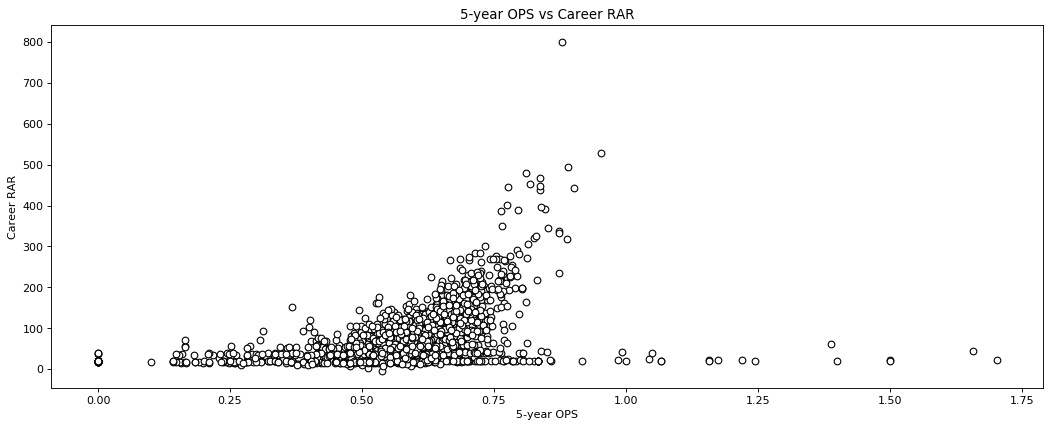

In [618]:
figure(figsize=(16, 6), dpi=80)
plt.scatter(career_stats['OPS'], career_stats['RAR'], c ="white",
            linewidths = 1,
            edgecolor ="black")

plt.title("5-year OPS vs Career RAR")
plt.xlabel("5-year OPS")
plt.ylabel("Career RAR")
plt.show()

In [619]:
top_OPS = career_stats[career_stats.OPS>1.25]
top_OPS[['nameFull','G','debutYear','finalYear','OPS']]

,nameFull,G,debutYear,finalYear,OPS
162,Ryan Brett,3,2015,2015,1.500000
750,Charlton Jimerson,30,2005,2008,1.388889
964,Keith McDonald,8,2000,2001,1.657407
1171,Yefri Perez,12,2016,2016,1.400000
1267,Carlos Rivero,4,2014,2014,1.702381
1506,Matt Tupman,1,2008,2008,1.500000


Predictably, many of the players with an abnormally high OPS but a low RAR also have very low number of career games due to an extremely small sample size. Because this would impact the efficacy of OBP/SLG as a predictor, I decided later to remove outliers of players that played in an extremely small number of games. 

### Stats from first five seasons

In [620]:
first_five_seasons = merged_RAA[merged_RAA.year_in_majors < 6]
first_five_seasons.columns

Index(['playerID', 'yearID', 'stint', 'teamID', 'lgID', 'G', 'AB', 'R', 'H',
       '2B', '3B', 'HR', 'RBI', 'SB', 'CS', 'BB', 'SO', 'IBB', 'HBP', 'SH',
       'SF', 'GIDP', 'OBP', 'SLG', 'OPS', 'PA', 'BA', 'ORAA', 'G_c', 'G_1b',
       'G_2b', 'G_3b', 'G_ss', 'G_lf', 'G_cf', 'G_rf', 'G_of', 'G_dh', 'DRAA',
       'RAA', 'RAR', 'nameFull', 'birthYear', 'height', 'bats', 'throws',
       'debutYear', 'AfterJuly', 'finalYear', 'active', 'Age',
       'year_in_majors', 'years_pre_majors', 'total_RAR'],
      dtype='object')

In [621]:
descriptive_stats_five_years = first_five_seasons.groupby(['playerID'])[['years_pre_majors','height','bats','throws']].max()
first_five_seasons_avgs = pd.DataFrame()

for avg_stat in ['BA','OBP','SLG','OPS']:
    first_five_seasons_avgs[avg_stat] = first_five_seasons.groupby('playerID').apply(w_avg, avg_stat, 'AB')

first_five_seasons_avgs

,BA,OBP,SLG,OPS
playerID,,,,
abadan01,0.111111,0.179894,0.111111,0.291005
abbotje01,0.263423,0.248488,0.416107,0.664595
abercre01,0.222798,0.227516,0.354922,0.582438
abernbr01,0.244240,0.241773,0.324885,0.566657
abreubo01,0.312739,0.327207,0.515036,0.842243
...,...,...,...,...
zaungr01,0.235521,0.269345,0.350064,0.619409
zawadla01,0.200000,0.255319,0.257143,0.512462
zoccope01,0.108108,0.139535,0.135135,0.274670


In [622]:
summed_first_five_seasons = first_five_seasons.groupby(['playerID','nameFull'])[["G","AB","R","H","2B","3B","HR","RBI","SB","CS","BB","SO",'IBB', 'HBP', 'SH',
       'SF', 'GIDP']].sum() #This is the table we'll be joining with for the rest of the document

In [623]:
len(summed_first_five_seasons)

1587

We currently have a total of 1587 total players, but I made the choice to remove outliers of players that played sparingly but had abnormally high averages due to a small sample size

In [624]:
summed_first_five_seasons = summed_first_five_seasons[summed_first_five_seasons.G > 20] 
summed_first_five_seasons = summed_first_five_seasons[summed_first_five_seasons.AB > 20] 

In [625]:
len(summed_first_five_seasons)

1257

After removing the players that played less than 20 games over their first 5 seasons, I was left with 1257 players. 

In [626]:
first_five_seasons_RAR = first_five_seasons.groupby(['playerID','nameFull'])[["DRAA","ORAA", "RAA","RAR"]].sum()

This feature was the player's accumulated DRAA and ORAA up to their first 5 seasons

In [627]:
summed_first_five_seasons = pd.merge(summed_first_five_seasons,first_five_seasons_avgs,on='playerID',how = 'left')

In [628]:
descriptive_stats

,Age,years_pre_majors,height,bats,throws,debutYear,finalYear,birthYear,prospect_years
nameFull,,,,,,,,,
A. J. Hinch,30,6,73.0,R,R,1998,2004,1974.0,0.0
A. J. Pierzynski,30,4,75.0,L,R,1998,2016,1976.0,0.0
Aaron Bates,25,7,76.0,R,R,2009,2009,1984.0,0.0
Aaron Boone,30,6,74.0,R,R,1997,2009,1973.0,1.0
Aaron Cunningham,26,4,71.0,R,R,2008,2012,1986.0,1.0
...,...,...,...,...,...,...,...,...,...
Zach Lutz,27,8,73.0,R,R,2012,2013,1986.0,0.0
Zach Sorensen,28,8,72.0,B,R,2003,2005,1977.0,0.0
Zach Walters,26,6,74.0,B,R,2013,2016,1989.0,0.0


In [629]:
summed_first_five_seasons = summed_first_five_seasons.drop(['BA','OPS'],axis = 1)
summed_first_five_seasons = pd.merge(summed_first_five_seasons,descriptive_stats_five_years,on='playerID',how = 'left')
summed_first_five_seasons = pd.merge(summed_first_five_seasons,first_five_seasons_RAR[["DRAA","ORAA"]],on='playerID',how = 'left')

In addition to the number of years the player spent in the minors, to incorporate the Top-100 Prospects list, I planned to use the number of years a player was a top prospect in the Minor-Leagues as a feature, it is also important to know that in the table `summed_first_five_seasons` the `'DRAA'` and `'ORAA'` stats are accumulated for the **first five** years of their careers, not the entire length.

In [630]:
summed_first_five_seasons = pd.merge(summed_first_five_seasons,career_stats[['playerID','prospect_years']],on = 'playerID',how = 'left')

In [631]:
summed_first_five_seasons

,playerID,G,AB,R,H,2B,3B,HR,RBI,SB,...,GIDP,OBP,SLG,years_pre_majors,height,bats,throws,DRAA,ORAA,prospect_years
0,abbotje01,233,596,82,157,33,2,18,83.0,6.0,...,12.0,0.248488,0.416107,7,74.0,R,L,-3.724077,-10.818729,2.0
1,abercre01,180,386,65,86,20,2,9,34.0,18.0,...,3.0,0.227516,0.354922,8,75.0,R,R,0.299623,-17.067133,0.0
2,abernbr01,232,868,97,212,36,5,8,79.0,21.0,...,15.0,0.241773,0.324885,6,73.0,R,R,3.812051,-40.509601,0.0
3,abreubo01,531,1829,312,572,117,29,65,273.0,81.0,...,32.0,0.327207,0.515036,4,72.0,L,R,-23.030950,103.350608,3.0
4,abreuto01,146,367,35,92,25,2,3,31.0,2.0,...,13.0,0.227432,0.354223,5,70.0,B,R,1.692500,-12.848003,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1265,youngma02,25,58,6,11,2,0,0,2.0,0.0,...,0.0,0.215610,0.224138,11,68.0,L,R,-0.427778,-4.820711,0.0
1266,youngmi02,584,2317,354,666,110,30,56,282.0,34.0,...,48.0,0.260684,0.433319,6,73.0,R,R,15.598716,-4.195018,0.0
1267,zaungr01,307,777,90,183,38,6,13,90.0,9.0,...,19.0,0.269345,0.350064,6,70.0,B,R,11.757190,-27.655390,0.0
1268,zuberjo01,68,136,13,34,7,1,3,16.0,1.0,...,4.0,0.256241,0.382353,9,73.0,L,L,-1.591111,-3.946042,0.0


In [632]:
# Adding handedness as a potential feature
bats = pd.get_dummies(summed_first_five_seasons['bats'])
bats.rename(columns={'B': "B_S", 'L': "B_L", 'R': "B_R"},inplace = True)
throws = pd.get_dummies(summed_first_five_seasons['throws'])
throws.rename(columns={'L': "T_L", 'R': "T_R"},inplace = True)

In [633]:
summed_first_five_seasons = summed_first_five_seasons.drop(['bats','throws'],axis = 1)
summed_first_five_seasons = summed_first_five_seasons.join(bats)
summed_first_five_seasons = summed_first_five_seasons.join(throws)

The following code blocks are to ensure that a player does not make their debut <5 years before the end of the timeframe of our data, as well as adding a feature if a player is already 25 when making their major league debut

In [634]:
temp_df = summed_first_five_seasons

temp_df = pd.merge(temp_df,merged_RAA.groupby('playerID')['Age'].min(),on = 'playerID',how='left')

def plus_25(row):
    if row['Age'] >= 25:
        return 1
    else:
        return 0
temp_df['plus_25'] = temp_df.apply (lambda row: plus_25(row), axis=1)

In [635]:
temp_df.rename(columns={"Age": "debut_age"},inplace = True)

In [636]:
summed_first_five_seasons = pd.merge(summed_first_five_seasons,temp_df[['playerID','debut_age','plus_25']],on = 'playerID',how='left')

In [637]:
def pre_2012(row):
    if row['debutYear'] < 2012:
        return 1
    else:
        return 0
merged_RAA['pre_2012'] = merged_RAA.apply (lambda row: pre_2012(row), axis=1)

In [638]:
pre_2012_RAA = merged_RAA[merged_RAA['pre_2012'] == 1]

In [639]:
summed_first_five_seasons = pd.merge(summed_first_five_seasons,pre_2012_RAA.groupby('playerID')['debutYear'].min(),how='inner',on='playerID')

#### Note: Initially I attempted to also include some percentage-based stats that were reflective of raw counts per plate appearance, but unfortunately I noticed dramatically lower results when compared to just using raw numbers.

### Visualization Insights

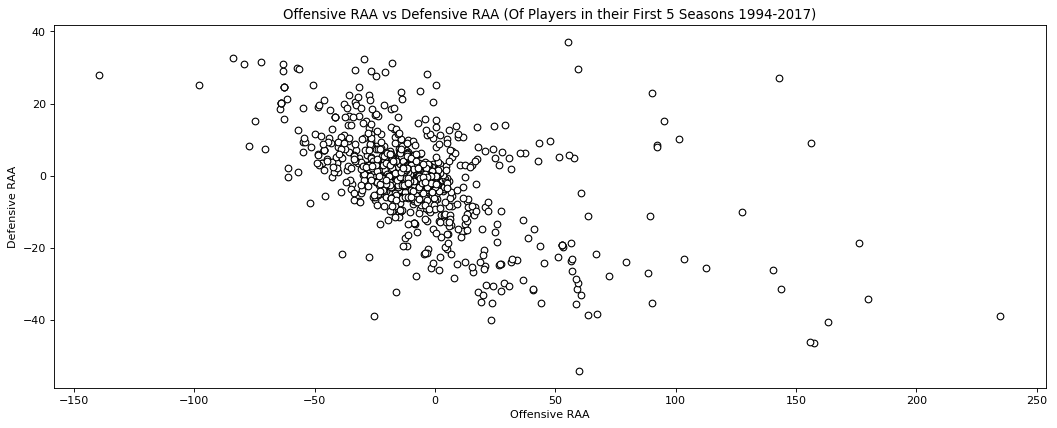

In [640]:
figure(figsize=(16, 6), dpi=80)
plt.scatter(summed_first_five_seasons['ORAA'],summed_first_five_seasons['DRAA'], c ="white",
            linewidths = 1,
            edgecolor ="black")

plt.title("Offensive RAA vs Defensive RAA (Of Players in their First 5 Seasons 1994-2017)")
plt.xlabel("Offensive RAA")
plt.ylabel("Defensive RAA")
plt.show()

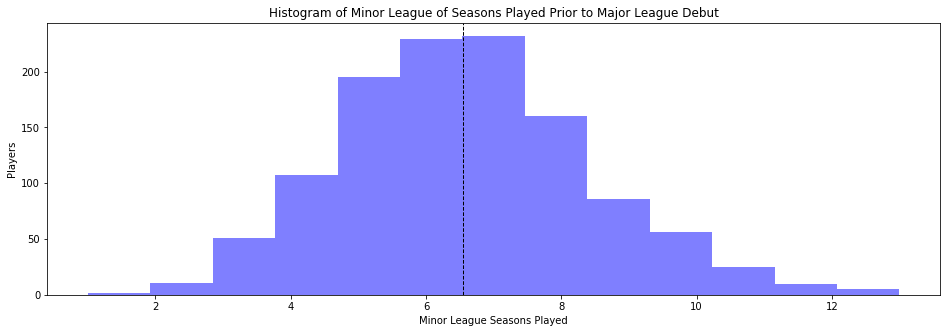

In [641]:
minors = summed_first_five_seasons['years_pre_majors']
num_bins = 13
plt.figure(figsize=(16,5),edgecolor='blue')
n, bins, patches = plt.hist(minors, num_bins, facecolor='blue', alpha=0.5)

plt.xlabel('Minor League Seasons Played')
plt.ylabel('Players')
plt.axvline(minors.mean(), color='k', linestyle='dashed', linewidth=1)
plt.title('Histogram of Minor League of Seasons Played Prior to Major League Debut')
plt.show()

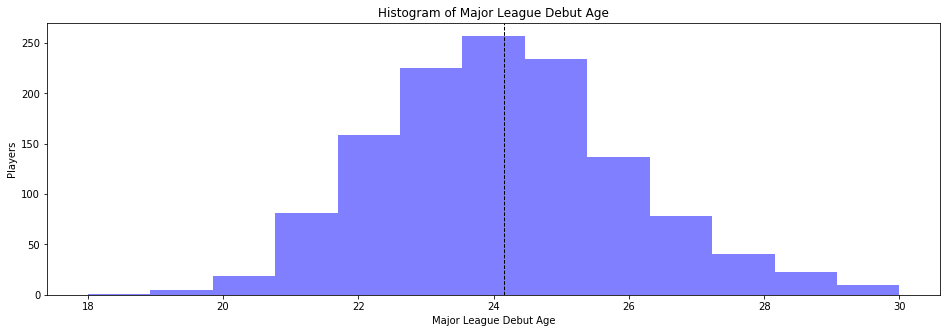

In [642]:
debut_age = temp_df['debut_age']
num_bins = 13
plt.figure(figsize=(16,5),edgecolor='blue')
n, bins, patches = plt.hist(debut_age, num_bins, facecolor='blue', alpha=0.5)

plt.xlabel('Major League Debut Age')
plt.ylabel('Players')
plt.axvline(debut_age.mean(), color='k', linestyle='dashed', linewidth=1)
plt.title('Histogram of Major League Debut Age')
plt.show()

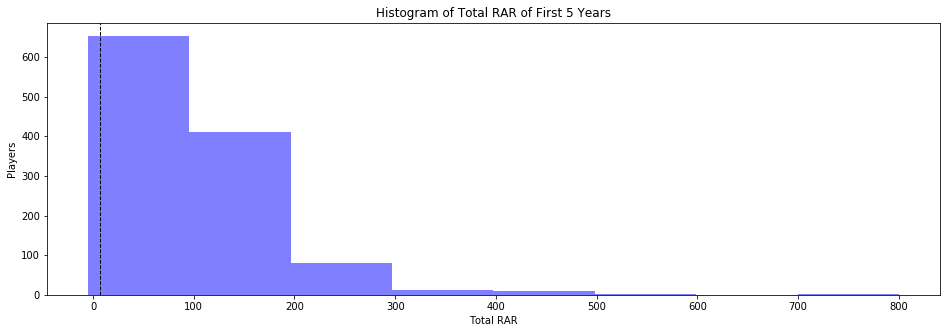

In [646]:
first_five_RAR = summed_first_five_seasons['total_RAR']
num_bins = 8
plt.figure(figsize=(16,5),edgecolor='blue')
n, bins, patches = plt.hist(first_five_RAR, num_bins, facecolor='blue', alpha=0.5)

plt.xlabel('Total RAR')
plt.ylabel('Players')
plt.axvline(minors.mean(), color='k', linestyle='dashed', linewidth=1)
plt.title('Histogram of Total RAR of First 5 Years')
plt.show()

### Feature Selection

Now that our data was finally collected, cleaned, and organized, it was time to determine which predictors we would include in the model. The first step was to create a correlation matrix that would analyze if any of the features strongly correlated with each other. Because the first type of model I was planning to use was Ordinary Least Squares, I first needed to make sure that my dataset satisfied the BLUE OLS assumptions.

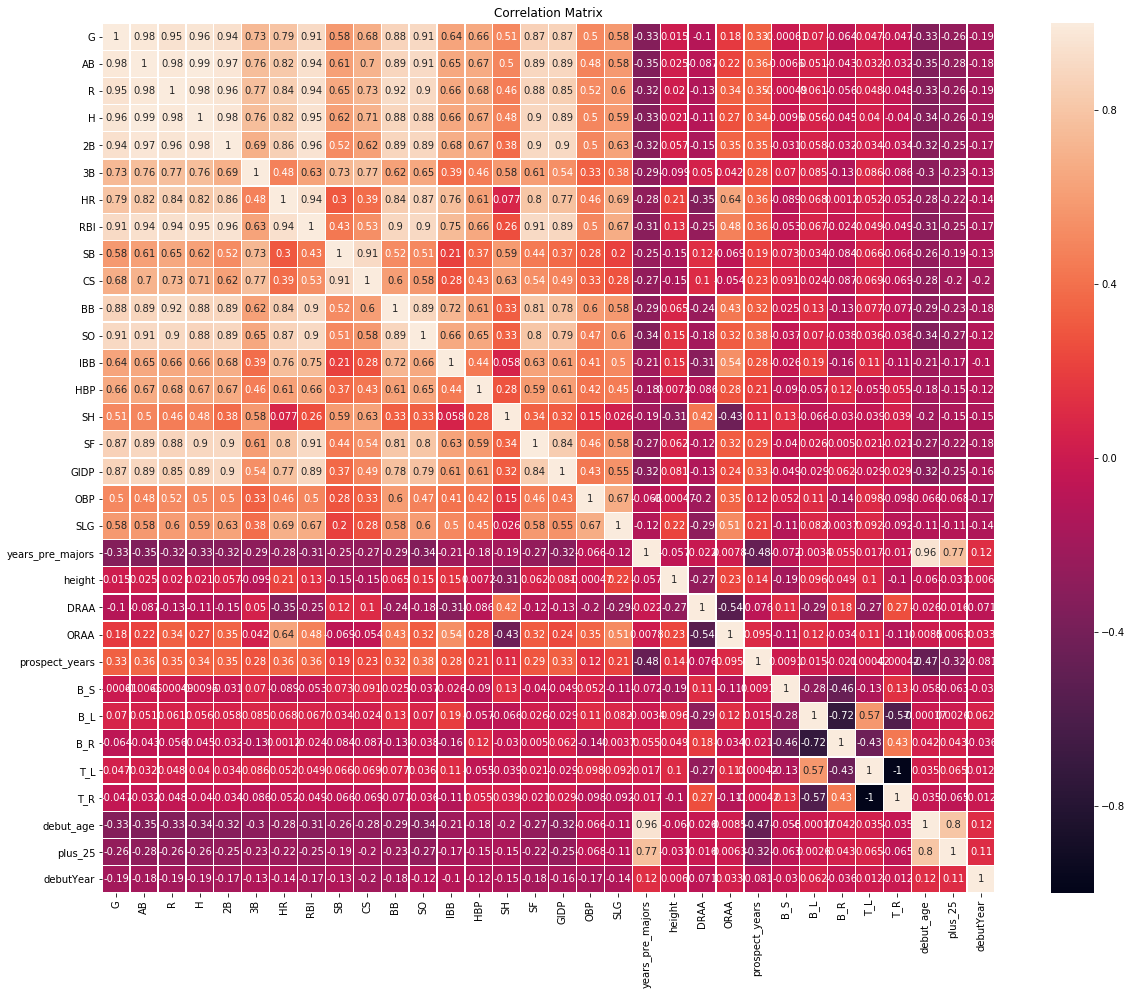

In [643]:
corrMatrix = summed_first_five_seasons.corr()
fig, ax = plt.subplots(figsize = (20, 16))

sns.heatmap(corrMatrix, annot = True, linewidths = 0.4, vmax = 1, vmin = -1)
plt.title('Correlation Matrix')
plt.show()

In [644]:
career_RAR = merged_RAA.groupby(['playerID'])[['total_RAR']].max() #Add career RAR as the dependent variable

In [645]:
summed_first_five_seasons = pd.merge(summed_first_five_seasons,career_RAR[['total_RAR']],on='playerID',how='left')

This next code block removes the features that are highly correlated to each other, and creates another correlation table with the remaining features in addition to seeing the correlation observed with our dependent variable of accumulated RAR at age 30. 

Variables Dropped: ['AB', 'R', 'H', '2B', 'RBI', 'CS', 'BB', 'SO', 'SF', 'T_R', 'debut_age']


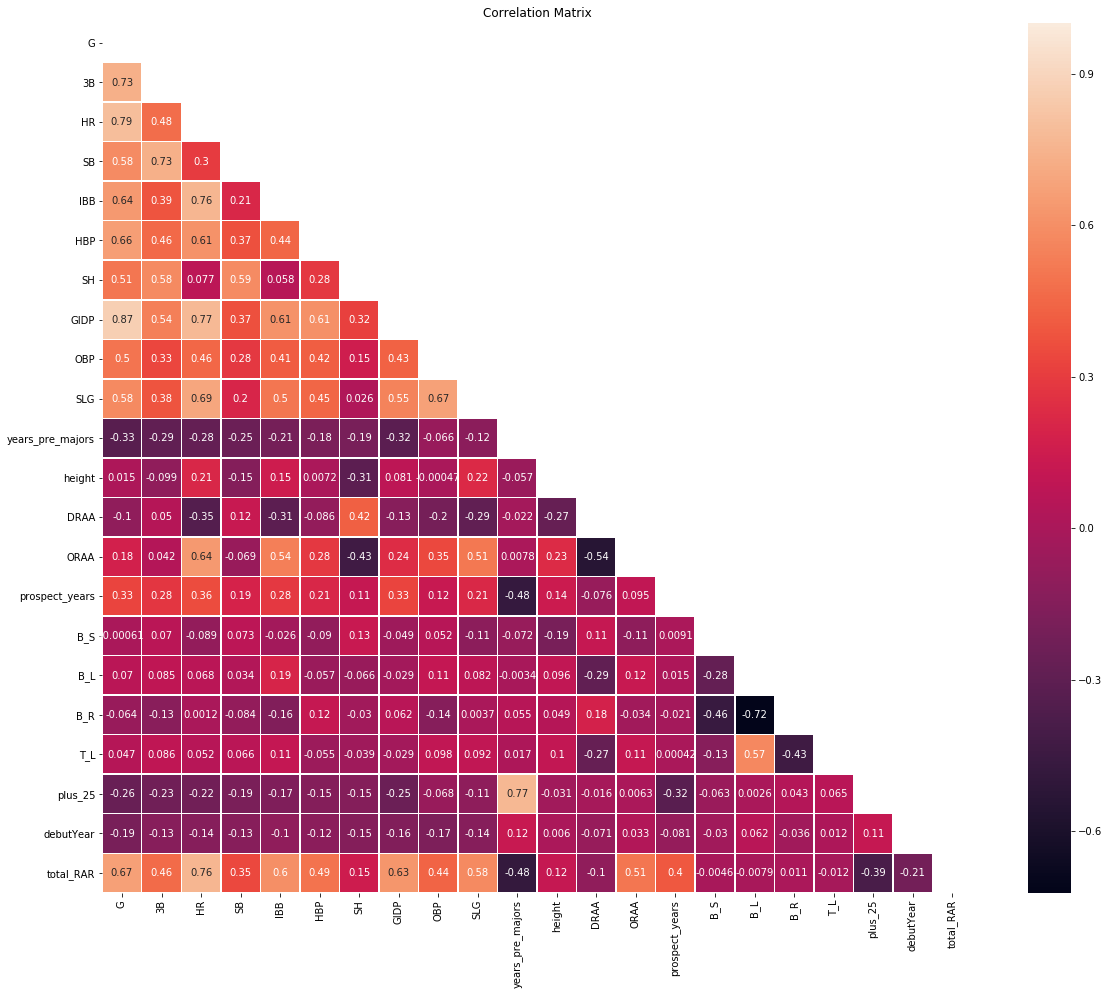

In [647]:
ind_vars_df = summed_first_five_seasons.iloc[:, summed_first_five_seasons.columns != 'total_RAR']

corrMatrix = abs(summed_first_five_seasons.corr())
upperTri = corrMatrix.where(np.triu(np.ones(corrMatrix.shape), k = 1).astype(np.bool))
vars_to_drop = [col for col in upperTri.columns if any(upperTri[col] >= 0.9)]
summed_first_five_seasons.drop(vars_to_drop, axis = 1, inplace = True)

print("Variables Dropped:",vars_to_drop)

# new correlation matrix 
new_corr = summed_first_five_seasons.corr()
fig, ax = plt.subplots(figsize = (20, 16))

mask = np.triu(np.ones_like(new_corr))
sns.heatmap(new_corr, mask = mask, square = True, linewidths = 0.5, annot = True, annot_kws = {'size': 10},
            xticklabels = new_corr.columns, yticklabels = new_corr.columns)
plt.title('Correlation Matrix')

plt.show()

In [648]:
summed_first_five_seasons.set_index('playerID',inplace = True)

The next step was to use Recursive Feature Selection to determine which features to use. After that I would calculate the p-values for statistical signficance as well as the Variance Inflation Factor to determine the level of multicollinearity.

In [649]:
x = summed_first_five_seasons.loc[:, summed_first_five_seasons.columns != 'total_RAR']
y = summed_first_five_seasons['total_RAR']
cols = list(x.columns)

model = LinearRegression()

rfe = RFE(estimator = model, n_features_to_select = 10, verbose = 10)
x_rfe = rfe.fit_transform(x, y)
model.fit(x_rfe, y)

temp = pd.Series(rfe.support_, index = cols)
selected_vars = list(temp[temp == True].index)
print('RFE Features: {}'.format(selected_vars))

Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
RFE Features: ['3B', 'OBP', 'SLG', 'years_pre_majors', 'DRAA', 'ORAA', 'prospect_years', 'T_L', 'plus_25', 'debutYear']


I selected 10 features to start off with, but based on the correlation table, I felt I had to make some judgement calls on what features to include. The factors I considered were the features' base correlation with age-30 RAR, the p-values from the OLS model, as well as the variance inflation factors.

I first noticed that the RFE method picked the Bats-Left, Bats-Right, as well as the Throws-Left features, which I thought would lead to multicollinearity and a poor R-squared score give that almost all batters are either left or right handed as well as throwing with the same hand. But it turned out not to be an issue as long as every categorical dummy variable **wasn't** included as a feature. However after testing out different combinations of including the bats/throws dummy variables, I found that the R-squared was not significantly affected if I removed them as features. 

The method also chose OBP, SLG, but given ORAA is a sum of a player's OPS across different seasons. Because ORAA is an adjusted stat by year, I decided to drop OBP and SLG and just keep ORAA as a feature, and testing the addition of DRAA even if the RFE function didn't include it also proved to have a positive effect on accuracy.

I was also not expecting triples to be included as a best feature given their relative rarity in today's game, and when I double-checked its correlation to age-30 cumulative RAR, I realized that home runs were still much more correlated, so I added home runs as a feature and noticed a dramatic improvement of more than .5 in R-squared.

Lastly, I was surprised Games Played was not included as an optimal feature, as I figured that playing time and the total number of games would play a large impact in the prediction. But because DRAA and ORAA are counting statistics heavily influenced by the number of appearances, it served as a sort of proxy for playing time.

In [673]:
#VIF
x_rfe_model = summed_first_five_seasons[['3B','HR', 'years_pre_majors', 'DRAA', 'ORAA', 'prospect_years', 'B_L', 'plus_25', 'debutYear']]
x_rfe_model = sm.add_constant(x_rfe_model.values)
y_rfe_model = summed_first_five_seasons['total_RAR']


lm = sm.OLS(y_rfe_model, x_rfe_model)
result_rs = lm.fit()
print(result_rs.summary())

vif = pd.DataFrame()
vif['Feature'] = lm.exog_names
vif['VIF'] = [variance_inflation_factor(lm.exog, i) for i in range(lm.exog.shape[1])]
print(vif[vif['Feature'] != 'const'])

                            OLS Regression Results                            
Dep. Variable:              total_RAR   R-squared:                       0.726
Model:                            OLS   Adj. R-squared:                  0.723
Method:                 Least Squares   F-statistic:                     340.5
Date:                Sun, 04 Dec 2022   Prob (F-statistic):          5.07e-318
Time:                        19:21:24   Log-Likelihood:                -5940.7
No. Observations:                1169   AIC:                         1.190e+04
Df Residuals:                    1159   BIC:                         1.195e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2766.8695    473.238      5.847      0.0

Now that we had decided on the total number of features to use, it was time to check the OLS assumptions of the features, making sure the features were indeed linear in nature as well as checking for heteroskedasticity and correlation.

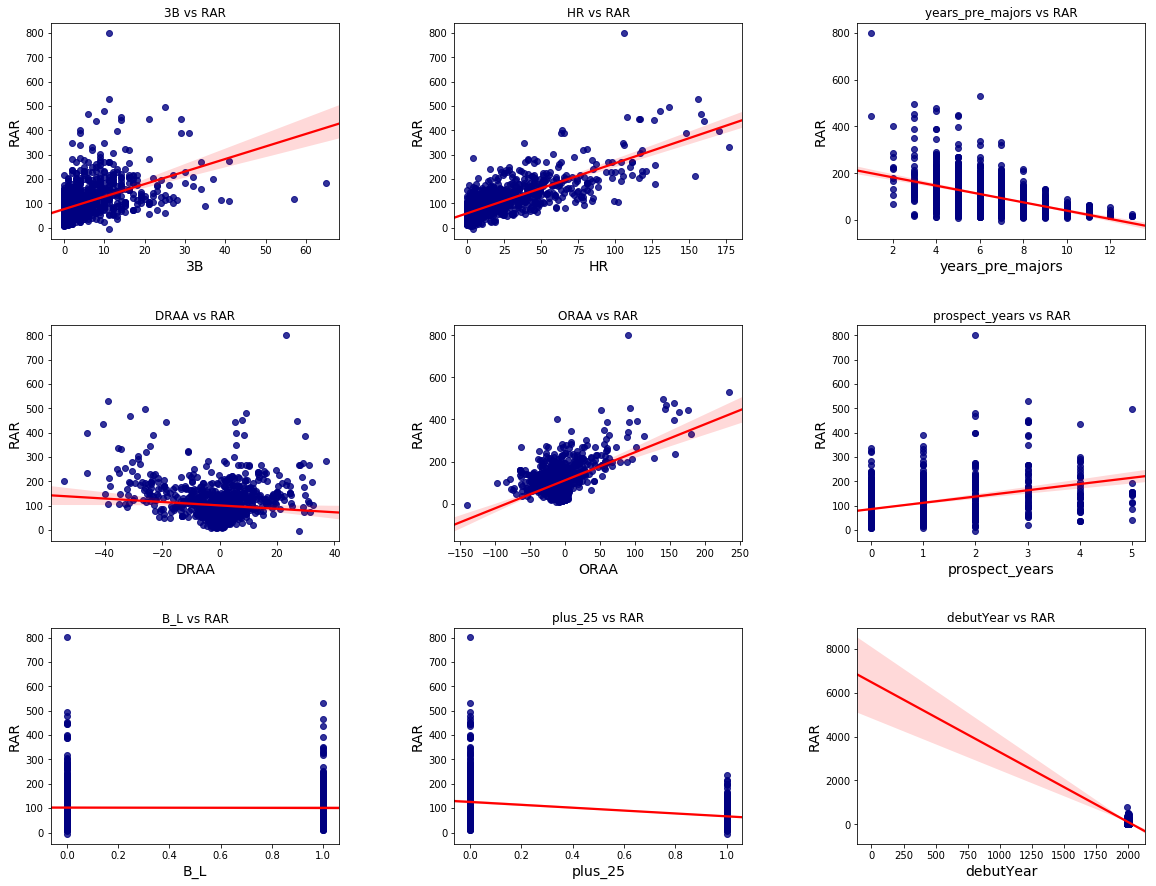

In [674]:
feature_df = summed_first_five_seasons.loc[:, ['total_RAR','3B','HR', 'years_pre_majors', 'DRAA', 'ORAA', 'prospect_years', 'B_L', 'plus_25', 'debutYear']]

# linearity
# scatter plots
cols = list(feature_df.drop('total_RAR', axis = 1).columns)

fig, axes = plt.subplots(3, 3, figsize = (8, 6))

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=2.0, 
                    top=2.0, 
                    wspace=0.4, 
                    hspace=0.4)

for col, ax in zip(cols, axes.flatten()[:10]):
    sns.regplot(x = col, y = 'total_RAR', data = feature_df, scatter_kws = {'color': 'navy'},
                line_kws = {'color': 'red'}, ax = ax)
    ax.set_title('{} vs RAR'.format(col), fontsize = 12)
    ax.set_xlabel(col, fontsize = 14)
    ax.set_ylabel('RAR', fontsize = 14)
    

plt.show()

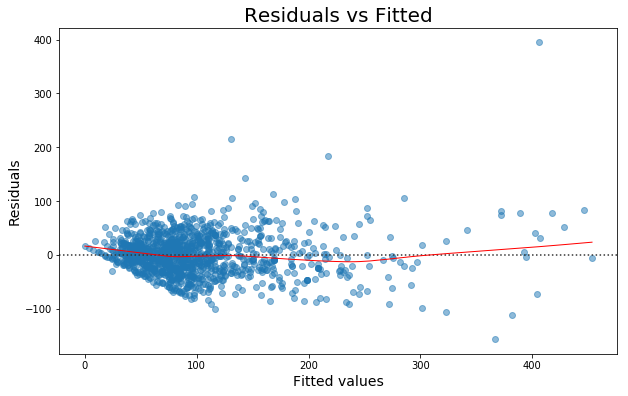

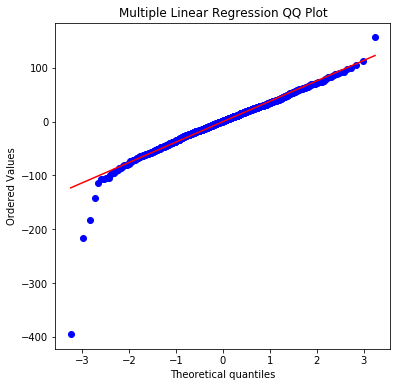

In [675]:
# homoscedasticity
# residual plot
x_rfe_model = summed_first_five_seasons[['3B','HR', 'years_pre_majors', 'DRAA', 'ORAA', 'prospect_years', 'B_L', 'plus_25', 'debutYear']]
x_rfe_model = sm.add_constant(x_rfe_model.values)

model = linear_model.LinearRegression().fit(x_rfe_model, y_rfe_model)
fitted_y = model.predict(x_rfe_model)
resid = fitted_y - y_rfe_model

fig = plt.subplots(figsize = (10, 6))
sns.residplot(fitted_y, "total_RAR", data = feature_df, lowess = True,
              scatter_kws = {"alpha": 0.5}, line_kws = {"color": "red", "lw": 1})
plt.xlabel("Fitted values", fontsize = 14)
plt.ylabel("Residuals", fontsize = 14)
plt.title("Residuals vs Fitted", fontsize = 20)
plt.show()

# normality
# QQ plot
fig = plt.subplots(figsize = (6, 6))
stats.probplot(resid, dist = "norm", plot = plt)
plt.title("Multiple Linear Regression QQ Plot")
plt.show()

#### OLS Analysis

Unfortunately, it appeared from the residuals plot that there was somewhat significant fanning observed where the variance of the residuals would increase as x increased. Basically what this means is that the Gauss-Markov assumption is violated, that Ordinary Least Squares estimators are not the BLUE (Best Linear Unbiased Estimators) for this particular problem and that using Multiple Linear Regression may not be the best solution to creating an accurate model. Among the individual linear plots there was also a similar increasing variance as the number of accumulated stats increased as seen with triples and home runs. Lastly, the data was also approximately normal, which was to be expected.

Despite that, the presence of heteroskedasticity does not necessarily mean that a linear regression cannot be done, so I decided to run a multiple linear model just to use a benchmark for other models I would try later.

In [667]:
def adj_r2(r_squared,n,p):
    adjusted = 1-(1-r_squared)*(n-1)/(n-p-1)
    return adjusted

In [676]:
X_lin = summed_first_five_seasons.loc[:, ['3B','HR', 'years_pre_majors', 'DRAA', 'ORAA', 'prospect_years', 'B_L', 'plus_25', 'debutYear']]
y_lin = summed_first_five_seasons.loc[:, ["total_RAR"]]
                                       
X_train, X_test, y_train, y_test = train_test_split(X_lin, y_lin, test_size=0.2)
  
mlr = linear_model.LinearRegression().fit(X_train, y_train)
y_predicted = mlr.predict(X_test)

In [677]:
# multiple linear regression results
print('------- Multiple Linear Regression -------')
print("Intercept: {}".format(mlr.intercept_))
print("Coefficients: {}".format(mlr.coef_))

print("R-squared: {}".format(metrics.r2_score(y_test, y_predicted)))
print("Adjusted R-squared: {}".format(adj_r2(metrics.r2_score(y_test, y_predicted),len(y_test),X_train.shape[1])))
mse = metrics.mean_squared_error(y_test, y_predicted)
print("RMSE: {}".format(math.sqrt(mse)))
print("MAE: {}".format(metrics.mean_absolute_error(y_test, y_predicted)))

------- Multiple Linear Regression -------
Intercept: [2616.87719995]
Coefficients: [[  1.233586     1.23002012 -10.11279581   1.63394528   0.92459496
    3.2625985   -4.53458787  -2.43320817  -1.23507412]]
R-squared: 0.654959420002859
Adjusted R-squared: 0.6410961824136882
RMSE: 38.61471272064317
MAE: 29.20439074622784


**The Multiple Regression yielded an adjusted R-squared of .641, and a root-mean squared error of 38.614**

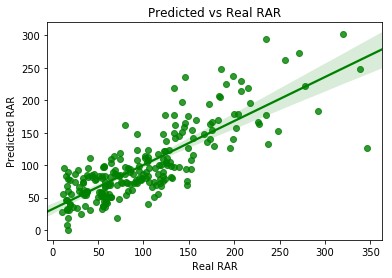

In [678]:
y_results = []
for i in y_predicted:
    y_results.append(i[0])
ax = sns.regplot(x=y_test['total_RAR'],y=np.array(y_results), color="g").set(title='Predicted vs Real RAR')
plt.xlabel("Real RAR")
plt.ylabel("Predicted RAR")
plt.show()

In [679]:
y_test.insert(loc=1,
          column='predicted_RAR',
          value=y_results)
y_test["difference"] = y_test['total_RAR']-y_test['predicted_RAR']
lin_predictions = pd.merge(y_test,career_stats,on='playerID',how='outer')

/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


The top three **Over-Predictions** from the Multiple Regression Model within the test set were:

In [680]:
top_3_over = lin_predictions.sort_values(by=['difference']).head(3)
top_3_over

,playerID,total_RAR,predicted_RAR,difference,nameFull,G,AB,R,H,2B,...,bats,throws,debutYear,finalYear,birthYear,prospect_years,BA,OBP,SLG,OPS
202,greenkh01,145.424060,235.990653,-90.566593,Khalil Greene,736,2567,322,628,157,...,R,R,2003,2009,1979.0,2.0,0.244644,0.248797,0.421893,0.670690
85,lawribr01,133.210718,218.831858,-85.621140,Brett Lawrie,588,2217,266,578,112,...,R,R,2011,2016,1990.0,3.0,0.260713,0.254552,0.419035,0.673587
79,gilje01,12.000823,95.969544,-83.968720,Jerry Gil,29,86,3,15,2,...,R,R,2004,2007,1982.0,0.0,0.174419,0.156863,0.220930,0.377793


There is some interesting context to explain why some of these careers did not pan out as expected. 



**Khalil Greene** was an extremely promising prospect at Clemson and finished 2nd in Rookie of the Year voting. He was a serviceable hitter while playing shortstop for the Padres before a streak of inconsistency after being traded to St. Louis led to the revelation that Greene had engaged in self-harm due to a poor start to the season. Later diagnosed as social anxiety disorder, a disease that Greene never fully recovered from while he was still an active player.

**Brett Lawrie** had some promising numbers early on in his career despite struggling with injuries, but petered out toward the end of his career as he never receive another major league contract especially after his time in Toronto ended with a string of injuries.

**Jerry Gil** was a pitcher that coincidentally converted to an outfielder, unfortuantely his hitting was not enough to succeed at the major league level despite possessing a strong arm.

The top three **Under-Predictions** from the Multiple Regression Model within the test set were:

In [683]:
top_3_under = lin_predictions.sort_values(by=['difference'],ascending=False).head(3)
top_3_under.dropna()

,playerID,total_RAR,predicted_RAR,difference,nameFull,G,AB,R,H,2B,...,bats,throws,debutYear,finalYear,birthYear,prospect_years,BA,OBP,SLG,OPS
169,ortizda01,346.162930,126.730221,219.432708,David Ortiz,1043,3666,622,1037,263,...,L,L,1997,2016,1975.0,1.0,0.282870,0.302638,0.549645,0.852283
219,leede02,291.871673,183.542487,108.329185,Derrek Lee,1235,4258,671,1177,260,...,R,R,1997,2011,1975.0,4.0,0.276421,0.293583,0.500000,0.793583
70,rossco01,237.677514,132.728902,104.948612,Cody Ross,757,2436,328,636,152,...,R,L,2003,2015,1980.0,0.0,0.261084,0.261617,0.455665,0.717282


As with the Over-Predictions, context can explain some of these anomalies

**David Ortiz** is most likely the most notable name on this list, who put up promising but not MVP calibre statistics with the Twins in his first five years before signing a contract with Boston and going on to a legendary Hall of Fame career of 3 World Series Rings, a WS MVP, 10 All-Star Appearances, and 7 Silver Sluggers, all as a DH.

**Derrek Lee** was a plus defender and 2x All-Star as he slowly developed into an elite hitter with the Marlins, where he showed good but not great statistics in the first five years of Major League service time.

**Cody Ross** differs from the other two players in the sense that he never really achieved All-Star status but managed to stick around in the majors long enough to accrue a great deal of RAR, more than might have been expected by a player with a lackluster first five seasons.

### Cross-Validation

Since a single linear model can be prone to variance in fit, we also need to cross-validate across several folds. In this case, we determined that the mean R-squared was a bit lower than the model we chose.

In [299]:
model = LinearRegression()
x = summed_first_five_seasons.loc[:, ['3B','HR','ORAA','DRAA', 'years_pre_majors','debutYear', 'prospect_years', 'B_L', 'plus_25']]
y = summed_first_five_seasons.loc[:, ["total_RAR"]]

cv_r2 = adj_r2(cross_val_score(model, x, y, scoring = "r2", cv = 10),len(x),x.shape[1])
cv_rmse = -1 * cross_val_score(model, x, y, scoring = "neg_root_mean_squared_error", cv = 10)
cv_mae = -1 * cross_val_score(model, x, y, scoring = "neg_mean_absolute_error", cv = 10)

print("------- Multiple Linear Regression Cross-Validation -------")
print("Mean Adj R-squared: {}".format(cv_r2.mean()))
print("Mean RMSE: {}".format(cv_rmse.mean()))
print("Mean MAE: {}".format(cv_mae.mean()))

------- Multiple Linear Regression Cross-Validation -------
Mean Adj R-squared: 0.6948895298418081
Mean RMSE: 39.36546647019126
Mean MAE: 29.698847538535908


In addition, I wanted to see if a single predictor might perhaps be better at predicting RAR, which turned out to be measurably false.

In [300]:
for i in summed_first_five_seasons.columns[1:-1]:
    X_lin = summed_first_five_seasons.loc[:, [i]]
    y_lin = summed_first_five_seasons.loc[:, ["total_RAR"]]

    X_train, X_test, y_train, y_test = train_test_split(X_lin, y_lin, test_size=0.2)

    mlr = linear_model.LinearRegression().fit(X_train, y_train)
    y_predicted = mlr.predict(X_test)

    print('------- Univariate Linear Regression Variable: ',i)

    print("Adjusted R-squared: {}".format(adj_r2(metrics.r2_score(y_test, y_predicted),len(X_train),1)))
    mse = metrics.mean_squared_error(y_test, y_predicted)
    print("RMSE: {}".format(math.sqrt(mse)))
    print("MAE: {}".format(metrics.mean_absolute_error(y_test, y_predicted)))

------- Univariate Linear Regression Variable:  3B
Adjusted R-squared: 0.2263408750118039
RMSE: 67.74169864286083
MAE: 47.954707500600016
------- Univariate Linear Regression Variable:  HR
Adjusted R-squared: 0.5320385046064606
RMSE: 44.07575820510795
MAE: 32.88895365747051
------- Univariate Linear Regression Variable:  SB
Adjusted R-squared: -0.2067270739420748
RMSE: 62.43185614547935
MAE: 46.827914505401864
------- Univariate Linear Regression Variable:  IBB
Adjusted R-squared: 0.34747695037918713
RMSE: 55.3515537540287
MAE: 40.90301671781682
------- Univariate Linear Regression Variable:  HBP
Adjusted R-squared: 0.229596463307416
RMSE: 75.96208303912266
MAE: 46.16424189637081
------- Univariate Linear Regression Variable:  SH
Adjusted R-squared: 0.027616040578848366
RMSE: 64.05922858204755
MAE: 48.983785799560216
------- Univariate Linear Regression Variable:  OBP
Adjusted R-squared: 0.14380169239734342
RMSE: 56.054578340133176
MAE: 43.749149673842666
------- Univariate Linear Regr

### Non-Linear Models

Due to the presence of heteroskedasticity, most likely due to players that just barely made the cutoff of games played as well as some tremendously successful and long careers of players that were extreme outliers, I also decided to try out some non-linear, more complex models to see if they could do any better.

#### Polynomial Regression

In [301]:
# Polynomial Regression
X, y = summed_first_five_seasons[['3B','HR','ORAA','DRAA', 'years_pre_majors','debutYear', 'prospect_years', 'B_L', 'plus_25']], summed_first_five_seasons["total_RAR"]
poly = PolynomialFeatures(degree=2, include_bias=False)
poly_features = poly.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(poly_features, y, test_size=0.2, random_state=42)

In [302]:
poly_reg_model = LinearRegression()
poly_reg_model.fit(X_train, y_train)
poly_reg_y_predicted = poly_reg_model.predict(X_test)
poly_reg_rmse = np.sqrt(mean_squared_error(y_test, poly_reg_y_predicted))
print("Mean RMSE: {}".format(poly_reg_rmse))
cv_r2 = adj_r2(cross_val_score(poly_reg_model, X, y, scoring = "r2", cv = 10),len(X_train),X.shape[1])
cv_rmse = -1 * cross_val_score(poly_reg_model, X, y, scoring = "neg_root_mean_squared_error", cv = 10)
cv_mae = -1 * cross_val_score(poly_reg_model, X, y, scoring = "neg_mean_absolute_error", cv = 10)

print("------- Polynomial Regression (Degree = 2) Cross-Validation -------")
print("Mean Adjusted R-squared: {}".format(cv_r2.mean()))
print("Mean RMSE: {}".format(cv_rmse.mean()))
print("Mean MAE: {}".format(cv_mae.mean()))

Mean RMSE: 38.266060671125686
------- Polynomial Regression (Degree = 2) Cross-Validation -------
Mean Adjusted R-squared: 0.6942990309552555
Mean RMSE: 39.36546647019126
Mean MAE: 29.698847538535908


### Random Forest

In [303]:
x = summed_first_five_seasons[summed_first_five_seasons.columns.difference(['total_RAR', 'playerID'])]
y = summed_first_five_seasons['total_RAR']
cols = list(x.columns)

model = RandomForestRegressor()

rfe = RFE(estimator = model, n_features_to_select = 10, verbose = 10)
x_rfe = rfe.fit_transform(x, y)
model.fit(x_rfe, y)

temp = pd.Series(rfe.support_, index = cols)
selected_vars_forest = list(temp[temp == True].index)
print('RFE Features: {}'.format(selected_vars_forest))

Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
RFE Features: ['DRAA', 'G', 'HR', 'OBP', 'ORAA', 'SB', 'SLG', 'debutYear', 'plus_25', 'years_pre_majors']


In [304]:
x = summed_first_five_seasons.loc[:, selected_vars_forest]
y = summed_first_five_seasons.loc[:, ["total_RAR"]]

estimators = [1,10,50,100,250,500,1000]

forest_model = RandomForestRegressor()
forest_grid = dict(max_features = [1,2,3,4,5,6,'log2','sqrt'],n_estimators=estimators)
cv = KFold(n_splits=5, random_state=None, shuffle=False)
forest_grid_search = GridSearchCV(estimator=forest_model, param_grid=forest_grid, n_jobs=-1, cv=cv, scoring='r2',error_score=0)
forest_grid_result = forest_grid_search.fit(x,y.values.ravel())

In [305]:
print("Best: %f using %s" % (forest_grid_result.best_score_, forest_grid_result.best_params_))
means = forest_grid_result.cv_results_['mean_test_score']
stds = forest_grid_result.cv_results_['std_test_score']
params = forest_grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.763457 using {'max_features': 2, 'n_estimators': 500}


In [319]:
x = summed_first_five_seasons.loc[:, selected_vars_forest]
y = summed_first_five_seasons['total_RAR']

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
forest_model = RandomForestRegressor(max_features =2,n_estimators = 500)
forest_model.fit(X_train, y_train)
forest_y_predicted = forest_model.predict(X_test)
forest_rmse = np.sqrt(mean_squared_error(y_test, forest_y_predicted))

print("------- Random Forest Regression -------")
print("R-squared: {}".format(forest_model.score(X_test,y_test)))
print("Mean RMSE: {}".format(forest_rmse))

------- Random Forest Regression -------
R-squared: 0.7218622782294152
Mean RMSE: 44.35169766303168


### Boosted Trees

In [306]:
x = summed_first_five_seasons[summed_first_five_seasons.columns.difference(['total_RAR', 'playerID'])]
y = summed_first_five_seasons['total_RAR']
cols = list(x.columns)

model = xgb.XGBRegressor(objective ='reg:squarederror', seed = 123)

rfe = RFE(estimator = model, n_features_to_select = 10, verbose = 10)
x_rfe = rfe.fit_transform(x, y)
model.fit(x_rfe, y)

temp = pd.Series(rfe.support_, index = cols)
selected_vars_boost = list(temp[temp == True].index)
print('RFE Features: {}'.format(selected_vars_boost))

Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.


/Applications/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Applications/anaconda3/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


RFE Features: ['DRAA', 'G', 'HR', 'OBP', 'ORAA', 'SB', 'SLG', 'plus_25', 'prospect_years', 'years_pre_majors']


In [307]:
x = summed_first_five_seasons.loc[:, selected_vars_boost]
y = summed_first_five_seasons.loc[:, ["total_RAR"]]

estimators = [100,250,500,1000]
learning_rate = [.001,.01,.1]

boost_model = xgb.XGBRegressor(objective ='reg:squarederror', seed = 123)
boost_grid = dict(learning_rate = learning_rate,n_estimators=estimators)
cv = KFold(n_splits=5, random_state=None, shuffle=False)
boost_grid_search = GridSearchCV(estimator=boost_model, param_grid=boost_grid, n_jobs=-1, cv=cv, scoring='r2',error_score=0)
boost_grid_result = boost_grid_search.fit(x,y.values.ravel())

In [308]:
print("Best: %f using %s" % (boost_grid_result.best_score_, boost_grid_result.best_params_))
means = boost_grid_result.cv_results_['mean_test_score']
stds = boost_grid_result.cv_results_['std_test_score']
params = boost_grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.765186 using {'learning_rate': 0.1, 'n_estimators': 100}


In [318]:
x = summed_first_five_seasons.loc[:, ['DRAA', 'G', 'HR', 'OBP', 'ORAA', 'SB', 'SLG', 'plus_25', 'prospect_years', 'years_pre_majors']
]
y = summed_first_five_seasons['total_RAR']

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
boost_model = xgb.XGBRegressor(objective ='reg:squarederror',n_estimators=100,learning_rate = .1)
boost_model.fit(X_train, y_train)
boost_y_predicted = boost_model.predict(X_test)
boost_rmse = np.sqrt(mean_squared_error(y_test, boost_y_predicted))

print("------- Random Forest Regression -------")
print("R-squared: {}".format(boost_model.score(X_test,y_test)))
print("Mean RMSE: {}".format(boost_rmse))

/Applications/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


------- Random Forest Regression -------
R-squared: 0.7633466902684571
Mean RMSE: 40.91067008332607


It appeared that the Gradient Boosted Trees Approach with a feature set of `['DRAA', 'G', 'HR', 'OBP', 'ORAA', 'SB', 'SLG', 'plus_25', 'prospect_years', 'years_pre_majors']
` had the highest R-squared out of the models that were tried.

### Conclusion

The final feature set using the Gradient Boosted Trees method that performed the best on the test set had a total of 10 features, Games Played, Home Runs, ORAA/DRAA, SB, SLG, if the player was already 25 when they made their debut, the number of years spent as a top prospect, as well as the number of years they spent in the minor leagues. I also found however, that taking out OBP and SLG from the feature set did not have a signficant effect on the performance of the model whenusing XGBoost, most likely due to the fact that OBP and SLG go into the ORAA metric anyway.

The cross-validated R-squared which was generated from the multiple linear regression was able to explain just under 72% of the total variation of a player's total expected RAR by their age 30 season. However, the residual plot from the OLS regression did appear to show signs of heteroskedasticity, which meant that there was not a constant variance across the data and estimators are not the BLUE (Best Linear Unbiased Estimators) for this particular problem.

I believe these issues mostly stemmed from the outliers in the dataset, while I removed players that played less than a certain number of games across their first five seasons, there were a few players that "slipped through the cracks" and barely qualified to make it into the dataset. Even after attempting to control for multicollinearity through the residual feature elimination method from sci-kit learn and the varaince inflation factors, I believe that these outliers were the reason the multiple linear model was not able to achieve a higher fit. 

In addition, I attempted to use several percentage based stats such as home runs/PA, but that unexpectedly led to a marked decrease in accuracy.

I also attempted to use several non-linear models to see if they could perform any better, including polynomial regression, tree-based regression models, of which the XGBoost performed the strongest, but not significantly better than the multiple linear model. 

In terms of future work if this project were to be built upon, I think it would be extremely helpful to be able to expand the dataset to include even more players to the present day, as well as being able to use the data of players that began their careers before 1994 but didn't reach their prime years until the late 90s or early 2000s. While I tried to remove the outliers on the lower end as much as possible by increasing the minimum number of games played, I found that taking out too many would overall hurt the efficacy of the model itself. 

**Citations:**

- https://scikit-learn.org/stable/modules/classes.html
- https://www.kaggle.com/code/sanghyunkim123/baseball-analytics-team-runs-scored-prediction/notebook#%E2%8F%B1-Cross-era-Comparison-
- https://pandas.pydata.org/docs/index.html
- https://matplotlib.org/stable/index.html
- https://www.statsmodels.org/stable/index.html
- https://en.wikipedia.org/wiki/Ordinary_least_squares